In [1]:
# Importing libraries

import requests
import pandas as pd
import numpy as np
import regex as re
from collections import OrderedDict

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess

import spacy

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
# Set the request parameters
url = 'https://dev97589.service-now.com/api/now/table/u_it_service_ticket_data?sysparm_limit=50000'

# Authentication
user = 'admin'
pwd = 'HwaV9p1GrMkL'

# Set proper headers
headers = {"Content-Type":"application/json","Accept":"application/json"}

# Do the HTTP request
response = requests.get(url, auth=(user, pwd), headers=headers )

# Check for HTTP codes other than 200
if response.status_code != 200: 
    print('Status:', response.status_code, 'Headers:', response.headers, 'Error Response:',response.json())
    exit()

# Decode the JSON response into a dictionary and use the data
ticket_data = response.json()

# inc_df = pd.read_csv('endava_incident.csv', header = 0)

In [3]:
inc_df = pd.DataFrame(ticket_data["result"])

inc_df = inc_df.rename(columns={'u_short_description': 'short_description', 
                            'u_description': 'description',
                            'u_ticket_type': 'ticket_type',
                            'u_category': 'category',
                            'u_sub_category1': 'sub_category1',
                            'u_sub_category2': 'sub_category2',
                            'u_business_service': 'business_service',
                            'u_urgency': 'urgency',
                            'u_impact': 'impact'})

In [4]:
# inc_df.to_csv('endava_incident.csv', index=False)
# inc_df = pd.read_csv('endava_incident.csv', header = 0)

# Converting to lowercase
inc_df = inc_df.apply(lambda x: x.astype(str).str.lower())

# To remove non-consecutive duplicates in each row of description
inc_df['description'] = (inc_df['description'].str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))

inc_df.shape

(48549, 27)

# Topic Modelling - LDA

### Data Pre-Processing for LDA Model 

In [5]:
# Remove stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'to', 'regards', 'thanks', 'thank', 'pm', \
                   'am', 'kind', 'kindly', 'kindest', 'let', 'po', 'dear', 'hi', 'hello', 'day',\
                   'fwd', 'please', 'attached', 'attach', 'find', 'asap', 'try', 'manager', 'get',\
                   'also', 'name', 'note', 'help', 'advise', 'need', 'require', 'send', 'follow',\
                   'provide', 'senior', 'want', 'head', 'lead', 'date'])

In [6]:
# Convert description field to list
data = inc_df.description.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [7]:
# Function to tokenize sentence to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Lemmatization done by keeping only noun, adjective, verb, and adverb
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### Text Vectorization

In [11]:
# Create the Document-Word matrix
# The LDA topic model algorithm requires a document word matrix as the main input.

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum required occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

# vectorizer.get_feature_names()

### Building LDA Models Using Sklearn

In [12]:
# Define Search Param
search_params = {'n_components': list(range(3, 16)), 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                          14, 15]})

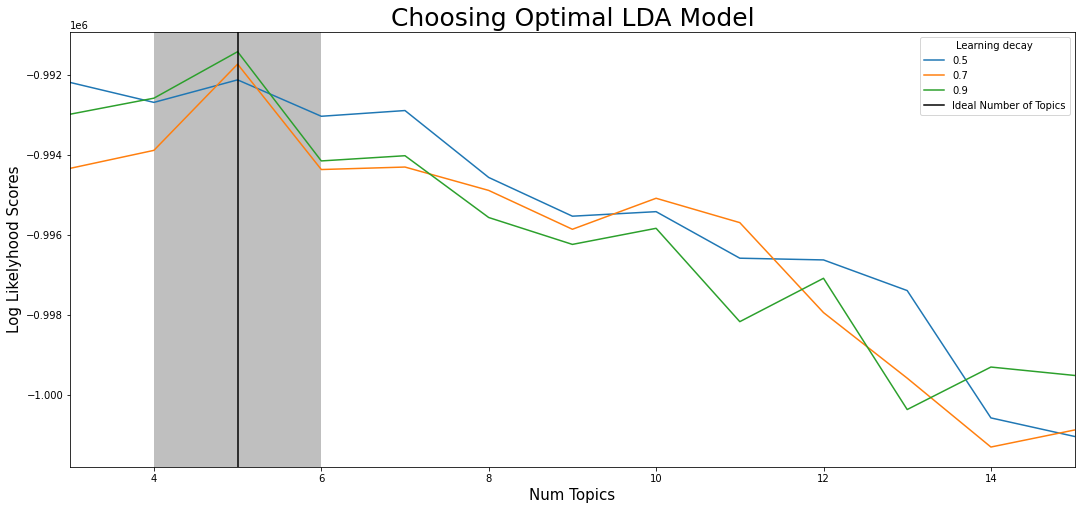

In [13]:
# Get Log Likelyhoods from Grid Search Output
n_topics = list(range(3, 16))

log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params'])\
                     if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params'])\
                     if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params'])\
                     if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(18, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.axvline(x=model.best_params_["n_components"], label='Ideal Number of Topics', color='black')
plt.axvspan(xmin=model.best_params_["n_components"] - 1, xmax=model.best_params_["n_components"] + 1, alpha=0.5, facecolor='grey')

plt.xlim([min(list(range(3, 16))), max(list(range(3, 16)))])

plt.title("Choosing Optimal LDA Model", fontsize=25)
plt.xlabel("Num Topics", fontsize=15)
plt.ylabel("Log Likelyhood Scores", fontsize=15)
plt.legend(title='Learning decay', loc='best')
#plt.legend(fontsize=20)
plt.show()

### Final LDA Model

In [14]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -991420.7252048159
Model Perplexity:  809.0748034670466


In [15]:
import joblib

# Save the best model
# joblib.dump(best_lda_model, 'lda_model.jl')

# Load the saved model
best_lda_model = joblib.load('lda_model.jl')

best_lda_model

LatentDirichletAllocation(learning_decay=0.9, n_components=5)

In [16]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
   
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.020000,0.020000,0.020000,0.020000,0.930000,4
Doc1,0.010000,0.210000,0.010000,0.010000,0.760000,4
Doc2,0.020000,0.160000,0.190000,0.020000,0.620000,4
Doc3,0.210000,0.090000,0.010000,0.010000,0.680000,4
Doc4,0.020000,0.020000,0.020000,0.020000,0.910000,4
Doc5,0.050000,0.000000,0.450000,0.300000,0.200000,2
Doc6,0.010000,0.010000,0.300000,0.010000,0.680000,4
Doc7,0.020000,0.020000,0.020000,0.020000,0.930000,4
Doc8,0.110000,0.130000,0.010000,0.080000,0.670000,4
Doc9,0.050000,0.670000,0.050000,0.180000,0.050000,1


In [17]:
df_document_topic['dominant_topic_labels'] = dominant_topic
df_document_topic['dominant_topic_labels'] = df_document_topic['dominant_topic_labels'].replace({0: 'Network' ,\
                                                                                                 1: 'Administrative',\
                                                                                                 2: 'Code',\
                                                                                                 3: 'Permission',\
                                                                                                 4: 'Connectivity'})
 
df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic,dominant_topic_labels
Doc0,0.02,0.02,0.02,0.02,0.93,4,Connectivity
Doc1,0.01,0.21,0.01,0.01,0.76,4,Connectivity
Doc2,0.02,0.16,0.19,0.02,0.62,4,Connectivity
Doc3,0.21,0.09,0.01,0.01,0.68,4,Connectivity
Doc4,0.02,0.02,0.02,0.02,0.91,4,Connectivity
...,...,...,...,...,...,...,...
Doc48544,0.02,0.74,0.02,0.02,0.21,1,Administrative
Doc48545,0.00,0.06,0.06,0.00,0.87,4,Connectivity
Doc48546,0.36,0.03,0.00,0.00,0.60,4,Connectivity
Doc48547,0.50,0.03,0.03,0.42,0.03,0,Network


In [18]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,16565
1,4,14333
2,3,8286
3,1,4700
4,0,4665


In [19]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abandon,ability,able,abort,abroad,absence,absolutely,academy,accelerate,accept,...,wrongly,xxx,yammer,year,yellow,yes,yesterday,zephyr,zip,zone
Topic0,0.203808,0.280243,93.204054,15.928113,1.253729,0.201244,1.666452,0.200424,0.208347,369.434611,...,0.201289,0.213999,0.200821,1.289318,12.899531,32.198324,76.890308,0.201596,17.802132,1.100629
Topic1,0.210160,0.201003,0.426030,0.201184,0.205059,0.200206,0.200433,0.200297,0.201246,0.200674,...,0.200237,15.740346,0.200224,2.317831,27.330418,0.200008,6.215761,0.200291,0.204657,213.783462
Topic2,0.209116,64.488974,0.201255,1.464944,4.749875,0.202310,13.560636,0.204129,13.186836,9.801613,...,12.577846,0.222367,0.201261,95.117398,27.821015,0.200318,67.932050,28.195603,12.577916,63.791853
Topic3,0.205754,28.096936,2.400693,0.202019,0.204575,0.323377,2.812563,14.194293,0.201484,943.357755,...,0.201282,0.209889,0.202546,29.146523,0.207954,0.200565,32.614203,0.201051,0.211426,191.573712
Topic4,14.171162,46.932844,1221.767967,0.203741,6.586763,645.072863,10.759915,0.200858,0.202088,0.205346,...,26.819347,3.613399,13.195147,192.128930,27.741082,0.200785,425.347678,0.201459,0.203869,38.750344


In [20]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  33.220635
2       51.163364 -159.968018       2        1  27.152594
3      -73.144554   21.523815       3        1  16.204861
0      -66.410133 -110.606438       4        1  13.711904
1       54.417324   12.443444       5        1   9.710007, topic_info=               Term         Freq        Total Category  logprob  loglift
2252       purchase  3898.000000  3898.000000  Default  30.0000  30.0000
73    administrator  3580.000000  3580.000000  Default  29.0000  29.0000
1665            log  7333.000000  7333.000000  Default  28.0000  28.0000
1946          order  4848.000000  4848.000000  Default  27.0000  27.0000
2320        receive  7162.000000  7162.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
2456        request   602.138003  3965.365995   Topic5  -4.7619   0.4471
2931         tester   501.363720  2054.694643   Topic5  -4.9451   0.9215
1270           good   558.129821  6841.178608   Topic5  -4.8378  -0.1741
3123           user   510.611218  3768.297432   Topic5  -4.9268   0.3332
3103         update   480.030078  5364.899436   Topic5  -4.9886  -0.0818

[380 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.924240     able
2         3  0.001544     able
2         4  0.073352     able
5         1  0.998506  absence
9         2  0.007532   accept
...     ...       ...      ...
3226      5  0.028970     work
3237      1  0.067712    write
3237      2  0.294702    write
3237      3  0.578632    write
3237      4  0.057709    write

[809 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

In [21]:
# Get the top 15 keywords for each topic

# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,connect,information,receive,work,error,send,message,change,confidential,fail,server,phone,notify,delete,expire
Topic 1,purchase,administrator,log,order,receive,item,receipt,section,installation,monitor,mandatory,phone,consideration,video,allocation
Topic 2,create,officer,add,form,change,good,need,update,analyst,user,code,make,work,ask,ext
Topic 3,engineer,good,site,link,share,assign,file,folder,request,add,work,permission,create,want,right
Topic 4,send,issue,error,log,submit,try,problem,work,receive,report,access,update,number,ticket,check


### Testing the prediction  of a new incident ticket using the best LDA Model
sent_to_words() –> lemmatization() –> vectorizer.transform() –> best_lda_model.transform()

In [22]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["I am not able to submit timesheeet"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['send', 'issue', 'error', 'log', 'submit', 'try', 'problem', 'work', 'receive', 'report', 'access', 'update', 'number', 'ticket', 'check']


In [23]:
predict_topic(text = mytext)[1]

array([[0.0668568 , 0.06666694, 0.06666668, 0.06666988, 0.73313971]])

# Incident Classification Models

## LSTM - Long Short Term Memory

In [24]:
# Importing Libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
import random

In [25]:
vocab_size = 5000
embedding_dim = 32 #64
max_length = 60
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 0.8

In [26]:
inc_desc = data_lemmatized
team_labels = df_document_topic['dominant_topic_labels'].tolist()

In [27]:
# Splitting the data into train and test set

# Rows = 38839
train_size = int(len(inc_desc) * training_portion)

# Rows = 38839
train_inc_desc = inc_desc[0: train_size]
train_team_labels = team_labels[0: train_size]

# Rows = 9710
validation_inc_desc = inc_desc[train_size:]
validation_team_labels = team_labels[train_size:]

# Deciding the max_length parameter
# pd.DataFrame([len(listElem) for listElem in train_sequences])\
#                       .describe(percentiles = [.25, .5, .75, .9, .95, .99])

In [28]:
random.seed(10)
train_inc_desc, validation_inc_desc, train_team_labels, validation_team_labels = train_test_split(inc_desc, team_labels, test_size = 0.20, random_state = 168753)

In [29]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_inc_desc)
word_index = tokenizer.word_index

In [30]:
# Trimming and padding dataset based on the maxlen which is the maximum number of words in each row i.e; 60
train_sequences = tokenizer.texts_to_sequences(train_inc_desc)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_inc_desc)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [31]:
# Tokenizing the labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(team_labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_team_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_team_labels))

In [32]:
# Building the LSTM Model
model = tf.keras.Sequential([
    
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 32 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    
    tf.keras.layers.Dropout(0.5),
    
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 178,918
Trainable params: 178,918
Non-trainable params: 0
__________________________________________________

In [33]:
# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10

# Fitting the model
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
1214/1214 - 82s - loss: 0.9169 - accuracy: 0.6573 - val_loss: 0.5637 - val_accuracy: 0.7878
Epoch 2/10
1214/1214 - 73s - loss: 0.5405 - accuracy: 0.8130 - val_loss: 0.3887 - val_accuracy: 0.8687
Epoch 3/10
1214/1214 - 75s - loss: 0.4085 - accuracy: 0.8623 - val_loss: 0.3042 - val_accuracy: 0.8927
Epoch 4/10
1214/1214 - 74s - loss: 0.3448 - accuracy: 0.8836 - val_loss: 0.2769 - val_accuracy: 0.9004
Epoch 5/10
1214/1214 - 73s - loss: 0.3063 - accuracy: 0.8969 - val_loss: 0.2589 - val_accuracy: 0.9057
Epoch 6/10
1214/1214 - 74s - loss: 0.2781 - accuracy: 0.9049 - val_loss: 0.2543 - val_accuracy: 0.9092
Epoch 7/10
1214/1214 - 75s - loss: 0.2573 - accuracy: 0.9128 - val_loss: 0.2608 - val_accuracy: 0.9060
Epoch 8/10
1214/1214 - 93s - loss: 0.2475 - accuracy: 0.9126 - val_loss: 0.2533 - val_accuracy: 0.9102
Epoch 9/10
1214/1214 - 141s - loss: 0.2316 - accuracy: 0.9197 - val_loss: 0.2517 - val_accuracy: 0.9123
Epoch 10/10
1214/1214 - 101s - loss: 0.2205 - accuracy: 0.9238 - val_los

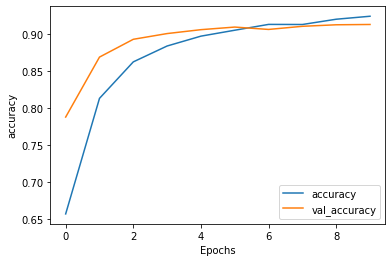

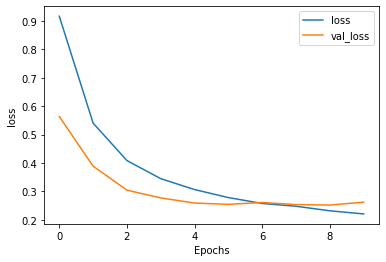

In [34]:
# Visualizing the accuracy of the model
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Evaluating performance of the LSTM model

In [35]:
test_df = pd.DataFrame(list(zip(validation_inc_desc, validation_team_labels)))
test_df.columns = ['inc_test_description', 'actual_label']
test_df['pred_labels'] = " "

In [36]:
for index, row in test_df.iterrows():
        txt = [test_df['inc_test_description'][index]]
        seq = tokenizer.texts_to_sequences(txt)
        padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
        pred = model.predict(padded)
        labels = ['Code', 'Connectivity', 'Permission', 'Administrative', 'Network']
        test_df['pred_labels'][index] = labels[np.argmax(pred)-1]

test_df

,inc_test_description,actual_label,pred_labels
0,thread ready guy believe legit pose cheer late...,Permission,Permission
1,information add patch somehow automate common ...,Code,Code
2,send permission error get try create branch se...,Connectivity,Connectivity
3,create ad add member owner engineer,Permission,Permission
4,directory next person tester person complete s...,Code,Code
...,...,...,...
9705,change guy form add assign complex ticket move...,Code,Code
9706,upgrade start try access link temporarily alre...,Permission,Permission
9707,correction assign information relate asset sta...,Code,Code
9708,check receive error massage form fail delete f...,Network,Network


In [37]:
predicted_team_labels = test_df['pred_labels']
confusion_matrix(validation_team_labels, predicted_team_labels)

array([[ 903,   33,   21,    9,    7],
       [  35, 3023,   97,   40,   85],
       [  17,   55, 2715,   72,   36],
       [  20,   22,   64,  730,   28],
       [  22,   84,   80,   21, 1491]], dtype=int64)

In [38]:
print(classification_report(validation_team_labels, predicted_team_labels))

                precision    recall  f1-score   support

Administrative       0.91      0.93      0.92       973
          Code       0.94      0.92      0.93      3280
  Connectivity       0.91      0.94      0.92      2895
       Network       0.84      0.84      0.84       864
    Permission       0.91      0.88      0.89      1698

      accuracy                           0.91      9710
     macro avg       0.90      0.90      0.90      9710
  weighted avg       0.91      0.91      0.91      9710



In [39]:
# Save the model
# model.save('lstm_model.h5')

In [40]:
# saving the tokenizer
# with open('tokenizer.pickle', 'wb') as handle:
    # pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)